# Example: Sizing a plant to meet constant electrical load

##
**Imports**

Install hydesign if needed.
Import basic libraries. 
Import HPP model assembly class.
Import the examples file path.

In [2]:
# Install hydesign if needed
import importlib
if not importlib.util.find_spec("hydesign"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/hydesign.git   

In [3]:
import pandas as pd
import numpy as np
from hydesign.assembly.hpp_assembly_constantoutput import hpp_model_constant_output as hpp_model
from hydesign.examples import examples_filepath
import matplotlib.pyplot as plt

## Evaluation
First we evaluate a specific configuration. The minimum load constraint is implemented as a penalty, so not meeting it will result in severly penalized financial metrics as seen below:

In [4]:
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
name = 'France_good_wind'
ex_site = examples_sites.loc[examples_sites.name == name]
longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0].replace('.yml','_benchmark.yml')
H2_demand_fn = examples_filepath+ex_site['H2_demand_col'].values[0]

PPA = 40 # Euro/MWh
hpp = hpp_model(
    latitude=latitude,
    longitude=longitude,
    altitude=altitude,
    num_batteries = 10,
    work_dir = './',
    sim_pars_fn = sim_pars_fn,
    input_ts_fn = input_ts_fn,
    ppa_price = PPA,
    load_min = 3, #MW
    load_min_penalty = 100, #MEuro
    battery_deg = True,
)
x=[35.0, 300.0, 10.0, 3, 7.0, 30, 25.0, 180.0, 1.0, 30, 7, 10.0]


Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0


In [5]:
outs = hpp.evaluate(*x)

In [6]:
hpp.print_design(x, outs) 


Design:
---------------
clearance [m]: 35.000
sp [W/m2]: 300.000
p_rated [MW]: 10.000
Nwt: 3.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 30.000
surface_tilt [deg]: 25.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.000
b_P [MW]: 30.000
b_E_h [h]: 7.000
cost_of_battery_P_fluct_in_peak_price_ratio: 10.000


NPV_over_CAPEX: 0.024
NPV [MEuro]: 1.257
IRR: 0.060
LCOE [Euro/MWh]: 60.573
CAPEX [MEuro]: 51.866
OPEX [MEuro]: 0.825
Wind CAPEX [MEuro]: 30.446
Wind OPEX [MEuro]: 0.690
PV CAPEX [MEuro]: 6.900
PV OPEX [MEuro]: 0.135
Batt CAPEX [MEuro]: 11.536
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 2.985
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.528
AEP [GWh]: 79.189
GUF: 0.904
grid [MW]: 10.000
wind [MW]: 30.000
solar [MW]: 30.000
Battery Energy [MWh]: 210.000
Battery Power [MW]: 30.000
Total curtailment [GWh]: 1624.454
Awpp [km2]: 4.286
Apvp [km2]: 0.368
Plant area [km2]: 4.286
Rotor diam [m]: 206.013
Hub height [m]: 138.006
Number of batteries used in lifetime: 2.000


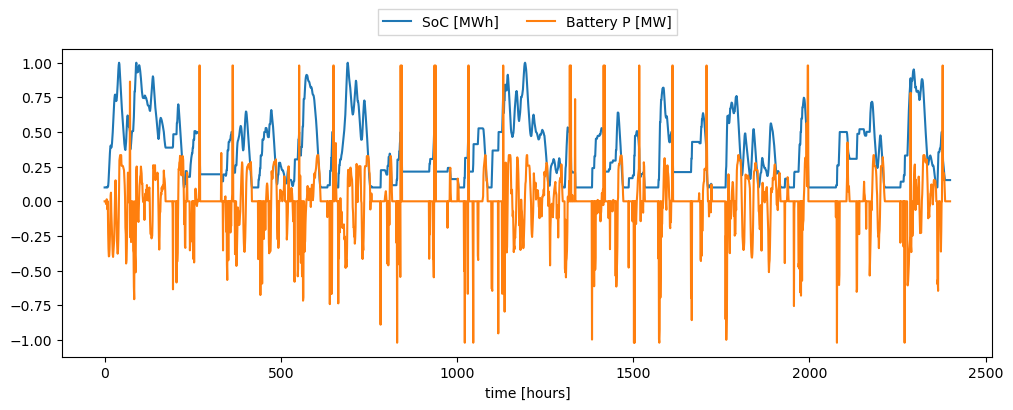

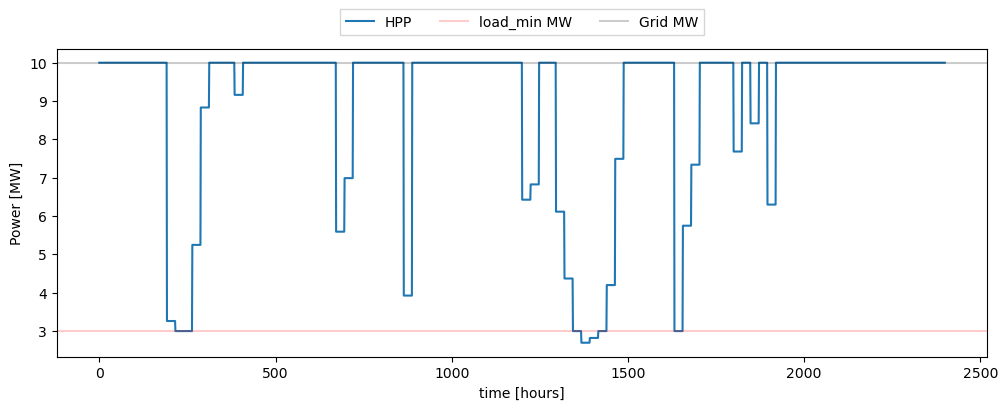

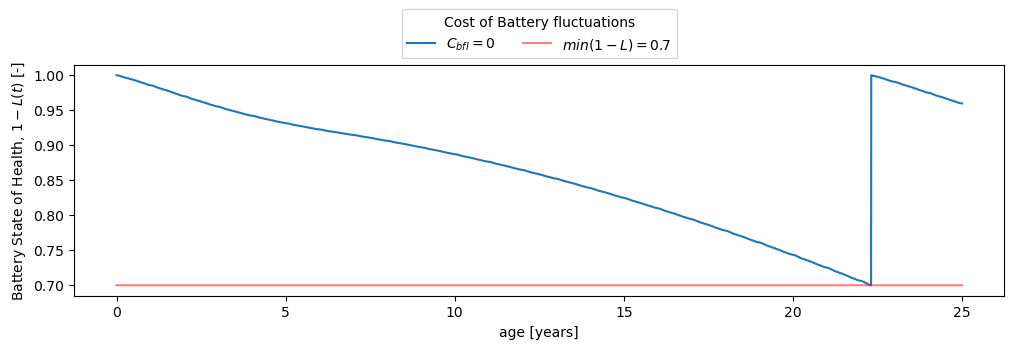

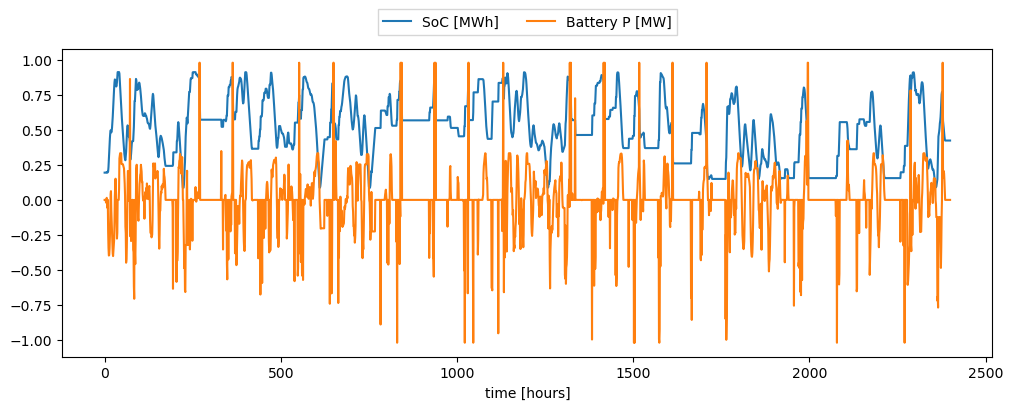

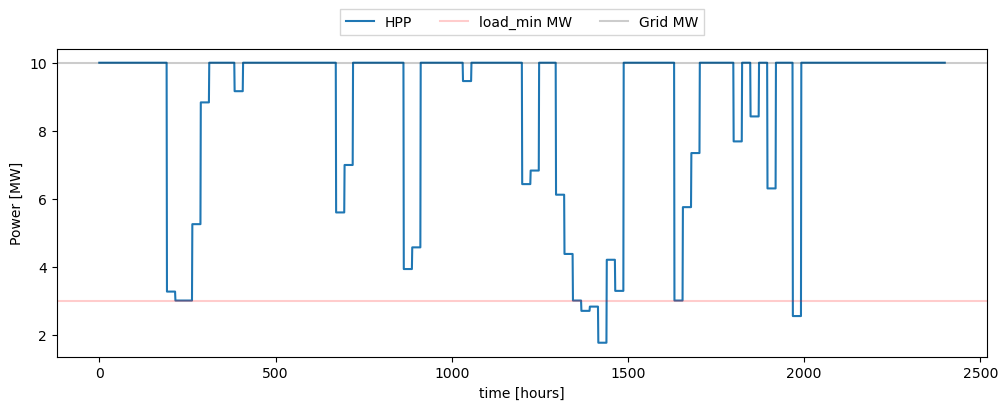

In [7]:
G_MW = hpp.prob['G_MW'] 
b_P = hpp.prob['b_P']
b_E = hpp.prob['b_E']
load_min = hpp.prob['load_min']

b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
b_t = hpp.prob.get_val('ems.b_t')
price_t = hpp.prob.get_val('ems.price_t')

wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('ems.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
grid_MW = hpp.prob.get_val('ems.G_MW')


n_start = int(24*365*7.2) 
n_days_plot = 100



plt.figure(figsize=[12,4])
# plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[n_start:n_start+24*n_days_plot]/b_E, label='SoC [MWh]')
plt.plot(b_t[n_start:n_start+24*n_days_plot]/b_P, label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
# plt.plot(wind_t[n_start:n_start+24*n_days_plot], label='wind')
# plt.plot(solar_t[n_start:n_start+24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
# plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')

plt.axhline(load_min, label='load_min MW', color='r', alpha = 0.2)
plt.axhline(grid_MW, label='Grid MW', color='k', alpha = 0.2)
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)
plt.show()

N_life = hpp.sim_pars['N_life']
life_h = N_life*365*24
age = np.arange(life_h)/(24*365)

SoH = np.copy(hpp.prob.get_val('battery_degradation.SoH'))
plt.figure(figsize=[12,3])
plt.plot( age, SoH, label=r'$C_{bfl}=0$')
plt.plot( age, 0.7*np.ones_like(age), label=r'$min(1-L) = 0.7$', color='r',alpha=0.5)
plt.xlabel('age [years]')
plt.ylabel(r'Battery State of Health, $1-L(t)$ [-]')
plt.legend(title='Cost of Battery fluctuations',
            loc='upper center', bbox_to_anchor=(0.5, 1.27),
            ncol=3, fancybox=0, shadow=0)
plt.show()  


b_E_SOC_t = hpp.prob.get_val('ems_long_term_operation.b_E_SOC_t_with_deg')
b_t = hpp.prob.get_val('ems_long_term_operation.b_t_with_deg')
price_t = hpp.prob.get_val('ems.price_t')

hpp_t = hpp.prob.get_val('ems_long_term_operation.hpp_t_with_deg')
hpp_curt_t = hpp.prob.get_val('ems_long_term_operation.hpp_curt_t_with_deg')
grid_MW = hpp.prob.get_val('ems.G_MW')


n_start = int(24*365*7.2) 
n_days_plot = 100



plt.figure(figsize=[12,4])
# plt.plot(price_t[:24*n_days_plot], label='price')
plt.plot(b_E_SOC_t[n_start:n_start+24*n_days_plot]/b_E, label='SoC [MWh]')
plt.plot(b_t[n_start:n_start+24*n_days_plot]/b_P, label='Battery P [MW]')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)

plt.figure(figsize=[12,4])
# plt.plot(wind_t[n_start:n_start+24*n_days_plot], label='wind')
# plt.plot(solar_t[n_start:n_start+24*n_days_plot], label='PV')
plt.plot(hpp_t[:24*n_days_plot], label='HPP')
# plt.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')

plt.axhline(load_min, label='load_min MW', color='r', alpha = 0.2)
plt.axhline(grid_MW, label='Grid MW', color='k', alpha = 0.2)
plt.xlabel('time [hours]')
plt.ylabel('Power [MW]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=5, fancybox=0, shadow=0)


In [8]:
hpp_t = hpp.prob.get_val('ems_long_term_operation.hpp_t_with_deg')
penalty_t_with_deg = hpp.prob.get_val('ems_long_term_operation.penalty_t_with_deg')

df_aux = pd.DataFrame(
    index = range(len(hpp_t)),
)
df_aux['day'] = np.floor(df_aux.index.values/24)
df_aux['hpp_t'] = hpp_t
df_aux['penalty_t'] = penalty_t_with_deg

aux_mins = np.repeat( df_aux.groupby('day').min().values, 24,axis=0)
df_aux['min_hpp_day'] = aux_mins[:,0]

load_min = hpp.load_min


# Get the number of days per year where the load is not meet
print ( len(df_aux.loc[df_aux['min_hpp_day']<load_min, 'day'].unique()) )

# get the year fraction when they start to occur
df_aux.loc[df_aux['min_hpp_day']<load_min, 'day'].unique()/365 


220


array([ 0.15616438,  0.15890411,  0.16164384,  0.22465753,  1.15616438,
        1.15890411,  1.16164384,  1.22465753,  1.92054795,  2.09863014,
        2.15616438,  2.15890411,  2.16164384,  2.22465753,  2.92054795,
        3.09863014,  3.15616438,  3.15890411,  3.16164384,  3.22465753,
        3.92054795,  4.09863014,  4.15616438,  4.15890411,  4.16164384,
        4.22465753,  4.92054795,  5.09863014,  5.15616438,  5.15890411,
        5.16164384,  5.22465753,  5.92054795,  6.09863014,  6.15616438,
        6.15890411,  6.16164384,  6.22465753,  6.92054795,  7.09863014,
        7.15616438,  7.15890411,  7.16164384,  7.22465753,  7.92054795,
        8.09863014,  8.15616438,  8.15890411,  8.16164384,  8.22465753,
        8.28493151,  8.92054795,  9.09863014,  9.15616438,  9.15890411,
        9.16164384,  9.22465753,  9.28493151,  9.92054795, 10.09863014,
       10.15616438, 10.15890411, 10.16164384, 10.22465753, 10.28493151,
       10.34246575, 10.92054795, 11.09863014, 11.15616438, 11.15

## Sizing
To optimize the size of the different technologies in order to meet the load we can do a sizing optimization:

In [9]:
from hydesign.Parallel_EGO import EfficientGlobalOptimizationDriver
import os

In [10]:
n_procs = int(os.cpu_count())

In [11]:
ex_site = examples_sites.loc[9]
longitude = ex_site['longitude']
latitude = ex_site['latitude']
altitude = ex_site['altitude']
input_ts_fn = examples_filepath+ex_site['input_ts_fn']
sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].replace('.yml','_benchmark.yml')
H2_demand_fn = examples_filepath+ex_site['H2_demand_col']
inputs = {
    'name': ex_site['name'],
    'longitude': longitude,
    'latitude': latitude,
    'altitude': altitude,
    'input_ts_fn': input_ts_fn,
    'sim_pars_fn': sim_pars_fn,
    'H2_demand_fn': H2_demand_fn,

    'opt_var': "NPV_over_CAPEX",
    'num_batteries': 10,
    'n_procs': n_procs - 1,
    'n_doe': 20,
    'n_clusters': 5,
    'n_seed': 0,
    'max_iter': 2,
    'final_design_fn': 'hydesign_design_0.csv',
    'npred': 3e4,
    'tol': 1e-6,
    'min_conv_iter': 3,
    'work_dir': './',
    'hpp_model': hpp_model,
    'PPA_price': 40,
    'load_min': 3, # MW
    'variables': {
    'clearance [m]':
        #{'var_type':'design',
        #  'limits':[10, 60],
        #  'types':'int'
        #  },
        {'var_type':'fixed',
           'value': 35
           },
    'sp [W/m2]':
        #{'var_type':'design',
        # 'limits':[200, 359],
        # 'types':'int'
        # },
        {'var_type':'fixed',
           'value': 300
           }, 
    'p_rated [MW]':
        {'var_type':'design',
          'limits':[1, 10],
          'types':'int'
          },
        # {'var_type':'fixed',
        #  'value': 6
         # },
    'Nwt':
        {'var_type':'design',
          'limits':[1, 400],
          'types':'int'
          },
        # {'var_type':'fixed',
        #   'value': 200
        #   },
    'wind_MW_per_km2 [MW/km2]':
        #{'var_type':'design',
        #  'limits':[5, 9],
        #  'types':'float'
        #  },
         {'var_type':'fixed',
           'value': 7
           },
    'solar_MW [MW]':
        {'var_type':'design',
           'limits':[1, 400],
           'types':'int'
          },
        #{'var_type':'fixed',
        #  'value': 20
        #  },
    'surface_tilt [deg]':
        # {'var_type':'design',
        #   'limits':[0, 50],
        #   'types':'float'
        #   },
        {'var_type':'fixed',
          'value': 25
          },
    'surface_azimuth [deg]':
        # {'var_type':'design',
        #   'limits':[150, 210],
        #   'types':'float'
        #   },
        {'var_type':'fixed',
          'value': 180
          },
    'DC_AC_ratio':
        # {'var_type':'design',
        #   'limits':[1, 2.0],
        #   'types':'float'
        #   },
        {'var_type':'fixed',
          'value':1.6,
          },
    'b_P [MW]':
        {'var_type':'design',
           'limits':[0, 100],
           'types':'int'
          },
        #{'var_type':'fixed',
        #  'value': 50
        #  },
    'b_E_h [h]':
        {'var_type':'design',
           'limits':[1, 10],
           'types':'int'
          },
        #{'var_type':'fixed',
        #  'value': 6
        #  },
    'cost_of_battery_P_fluct_in_peak_price_ratio':
        {'var_type':'design',
          'limits':[0, 20],
          'types':'float'
          },
#         {'var_type':'fixed',
#           'value': 10},
    }}



In [12]:
EGOD = EfficientGlobalOptimizationDriver(**inputs)
EGOD.run()
result = EGOD.result





Sizing a HPP plant at Denmark_good_wind:


Fixed parameters on the site
-------------------------------
longitude = 8.594398
latitude = 56.227322
altitude = 85.0



Initial 20 simulations took 1.47 minutes
  Current solution -NPV_over_CAPEX = 3.395E-01
  Current No. model evals: 20

Update sm and extract candidate points took 0.22 minutes
Check-optimal candidates: new 17 simulations took 1.62 minutes
  Current solution -NPV_over_CAPEX = -2.099E-02
  Current No. model evals: 36
  rel_yopt_change = -1.72E+01
Iteration 1 took 1.86 minutes

Update sm and extract candidate points took 0.23 minutes
Check-optimal candidates: new 17 simulations took 1.63 minutes
  Current solution -NPV_over_CAPEX = -1.698E-01
  Current No. model evals: 52
  rel_yopt_change = -8.76E-01
Iteration 2 took 1.88 minutes


Design:
---------------
clearance [m]: 35.000
sp [W/m2]: 300.000
p_rated [MW]: 1.000
Nwt: 14.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 53.000
surface_tilt [deg]: 25.000
surface_azimuth

# Export the DOE 

In [13]:
n_doe = inputs['n_doe']
n_seed = inputs['n_seed']
pd.DataFrame(
    columns = EGOD.kwargs['design_vars'],
    data = EGOD.xdoe).to_csv(f'DOE_n_doe_{n_doe}_seed_{n_seed}.csv')